date is 20150203
PnL for GOOG is -17.77
PnL for AAPL is -1.16
PnL for FB is -0.89
PnL for MSFT is -0.29
PnL for ORCL is -0.65
date is 20150204
PnL for GOOG is -8.34
PnL for AAPL is -0.62
PnL for FB is -1.32
PnL for MSFT is -0.53
PnL for ORCL is -0.3
date is 20150205
PnL for GOOG is -1.65
PnL for AAPL is 0.87
PnL for FB is -1.0
PnL for MSFT is -0.24
PnL for ORCL is -1.04
date is 20150206
PnL for GOOG is -36.1
PnL for AAPL is -0.87
PnL for FB is -1.95
PnL for MSFT is -0.76
PnL for ORCL is -0.89
date is 20150209
PnL for GOOG is -3.05
PnL for AAPL is -0.2
PnL for FB is -0.82
PnL for MSFT is -1.02
PnL for ORCL is -0.76
date is 20150210
PnL for GOOG is -33.84
PnL for AAPL is -1.03
PnL for FB is -0.83
PnL for MSFT is -0.73
PnL for ORCL is -1.35
date is 20150211
PnL for GOOG is -3.4
PnL for AAPL is 0.36
PnL for FB is -0.38
PnL for MSFT is 0.48
PnL for ORCL is -1.63
date is 20150212
PnL for GOOG is -0.93
PnL for AAPL is 0.03
PnL for FB is -2.03
PnL for MSFT is -0.5
PnL for ORCL is -0.8
date is 

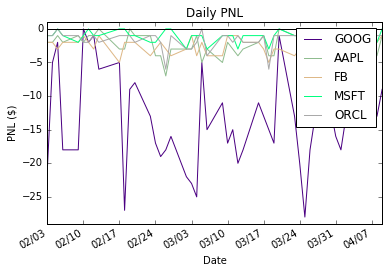

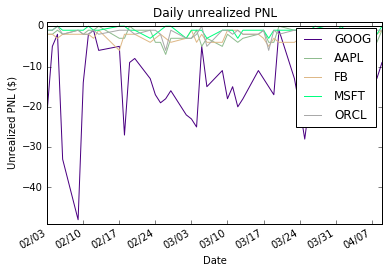

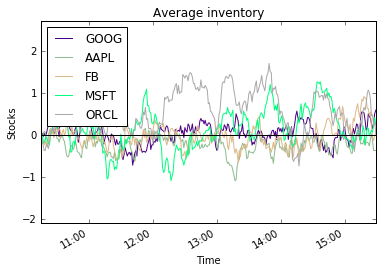

In [19]:
%matplotlib inline

import os
import sys
import time
import six
import simulator as sim
import numpy as np
import datetime as dt

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colors

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


SEC = 1000000
MIN = 60 * SEC
DOLLAR = 1000000
CENT = 10000

DATA_PATH = "data/"
OUTPUT_PATH = "output/"


##############################################################################
# Get last days from a reference date
##############################################################################


def get_last_days(dates, ref_date, num):
    last_dates = []
    # linear search right now
    ind = len(dates)
    for i in range(len(dates)):
        if dates[i] >= ref_date:
            ind = i
            break
    
    if ind < num:
        print "not enough historical data to get the last {0} days from {1}".format(num, ref_date)
        return []
    else:
        return dates[(i - num) : (i - 1)]

    
###############################################################################
# Algorithm
###############################################################################

class SVMAlgo:
    
    def __init__(self, session, date, ticker, start_time, end_time, generator, bld, nl):
        # Save session information
        self.session = session
        self.date = date
        self.tickers = ticker
        self.start_time = start_time
        self.end_time = end_time
        self.clfs = generator
        self.bld_up = bld
        self.num_levels = nl
        self.order_size = 1
        # PnL and book value functions need to be tested when order_size is not 1
        self.mu = 4 * CENT
        self.ORDER_WAIT = 30
        self.stop_loss_per_share_threshold = 10 * CENT
        print "date is {0}".format(date)
        # outstanding_orders is a dictionary, tickers are the keys and values are 
        # {"A": [ask_order_id, time_accepted], "B": [bid_order_id, time_accepted]}
        # if there are outstanding orders
        self.outstanding_orders = {}
        # signal is a dictionary : {symbol : symbol_signal}
        self.signal = {}
        
        # inventory is another dictionary: {symbol : inventory_size for symbol}
        # cash is another dictionary: {symbol : cash_balance for symbol}
        # bookvalue is another dictionary: {symbol : book value for symbol}
        self.inventory = {}
        self.cash = {}
        self.bookvalue = {}
        # self.inv_hist is a dict of numpy arrays, the arrays are as follows:
        # field for each column: time, symbol_cash, symbol_inventory, symbol_book_value, symbol_current_mid_price
        self.inv_hist = {}
        self.max_price = {}
        self.min_price = {}
        
        # Suscribe to tickers and set first timer
        # no trading on the 1st 15 minute: use to compute signal
        self.offset = 15 * MIN
        num = (end_time - start_time - self.offset) / MIN + 1
        self.obs_counter = 0
        
        self.ordbook_counter = 0
        # hist_ordbook is a dictionary : {symbol : hist_ordbook}
        self.hist_ordbook = {}
                    
        for sym_it in self.tickers:
            self.session.subscribe_ticker_all_feeds(sym_it)
            self.outstanding_orders[sym_it] = {}
            self.hist_ordbook[sym_it] = np.zeros(((end_time - start_time) / MIN, num_levels * 2))
            self.signal[sym_it] = 0
            self.inventory[sym_it] = 0
            self.cash[sym_it] = 0
            self.bookvalue[sym_it] = 0
            self.session.subscribe_event(sym_it, sim.ORDER_ACCEPTED, self.order_ack_callback)
            self.session.subscribe_event(sym_it, sim.ORDER_EXECUTED, self.order_exe_callback)
            self.session.subscribe_event(sym_it, sim.ORDER_CANCELED, self.cancelled_callback)
            self.session.subscribe_event(sym_it, sim.ORDER_REJECTED, self.rejected_callback)
            self.inv_hist[sym_it] = np.zeros((num, 5))
            self.max_price[sym_it] = 1*DOLLAR
            self.min_price[sym_it] = 1000*DOLLAR
        
        for i in range((end_time - start_time) / MIN):
            self.session.add_timer(self.start_time + i * MIN, self.timer_OBS_callback)
        
        self.session.add_timer(self.end_time, self.end_callback)
        
    def timer_OBS_callback(self, time):
        #print "OBS callback: {0}, {1}".format(sim.micro_to_time(time), sim.micro_to_time(self.end_time))
        # clear the stop_loss_sent every time
        for sym_it in self.tickers:
            book = self.session.get_book_levels(sym_it, nlevels = self.num_levels)
            bids = book["bids"]
            asks = book["asks"]
            
            for i in range(self.num_levels):
                self.hist_ordbook[sym_it][self.ordbook_counter, i] = asks[i]["size"]
                self.hist_ordbook[sym_it][self.ordbook_counter, i + 5] = bids[i]["size"]
        
        self.ordbook_counter += 1
            
        if (time >= self.start_time + self.offset):
            # print "OBS callback: {0}, {1}".format(sim.micro_to_time(time), sim.micro_to_time(self.end_time))
            for sym_it in self.signal:
                self.stop_loss_barrier(sym_it)
                curr_sig = self.get_signal(sym_it)
                # print "Current signal is {0}, signal before is {1}".format(curr_sig, self.signal[sym_it])
                if (curr_sig != self.signal[sym_it]):
                    self.cancel_orders(sym_it)
                    self.signal[sym_it] = curr_sig
                self.post_orders(sym_it)
            for sym_it in self.tickers:
                bid, ask = self.session.get_inside_market(sym_it)
                b_price = bid['price']
                a_price = ask['price']
                self.inv_hist[sym_it][self.obs_counter] = np.array([time, self.cash[sym_it], self.inventory[sym_it], self.bookvalue[sym_it], (a_price + b_price) / 2])

            self.obs_counter += 1    
            
            
    def post_orders(self, ticker):
        now = self.session.current_time()
        orders = self.session.get_orders_by_ticker(ticker)
        if not orders:
            bid, ask = self.session.get_inside_market(ticker)
            b_price = bid['price'] # = bestBidPrice()
            a_price = ask['price']
            self.max_price[ticker] = max(self.max_price[ticker], b_price)
            self.min_price[ticker] = min(self.min_price[ticker], b_price)
            self.session.add_order(ticker, sim.BUY, self.order_size, b_price - (self.signal[ticker] < 0) * self.mu, exchange=sim.EXCH_INET)
            self.session.add_order(ticker, sim.SELL, self.order_size, a_price + (self.signal[ticker] > 0) * self.mu, exchange=sim.EXCH_INET) 
            #print "Posted orders with ask = {0} and bid = {1}".format(a_price, b_price)
               
    
    def cancel_orders(self, ticker):
        now = self.session.current_time()
        #print "cancel order call back: it's now {0}".format(sim.micro_to_time(now))
        ord_info = self.outstanding_orders[ticker]
        if len(ord_info) == 0:
            #print "no order to cancel"
            return
        else:
            for side in ord_info:
                sim.cancel_order(ord_info[side][0])
                #print "cancelled order {0}".format(ord_info[side][0])
        
        
    def stop_loss_barrier(self, ticker):
        now = self.session.current_time()
        #print "stop loss for ticker {0} at {1}".format(ticker, sim.micro_to_time(now))
        inv = self.inventory[ticker]
        bv = self.bookvalue[ticker]
        #print "inv is {0}, book value is {1}".format(inv, bv)
        bid, ask = self.session.get_inside_market(ticker)
        b_price = bid['price']
        a_price = ask['price']
        
        if (inv > 0):
            if (b_price * inv > bv): # if we can have realized gain by selling inv we will do it
                self.liquidate(ticker)
            #elif (a_price * inv < bv - inv * self.stop_loss_per_share_threshold): # if unrealized loss is greater than threshold
            #    self.liquidate(ticker)
        elif (inv < 0):
            #print "ask price is {0}, bid price is {1}".format(a_price, b_price)
            if (a_price * inv - bv > 0):
                self.liquidate(ticker)
            #elif (b_price * inv - bv < inv * self.stop_loss_per_share_threshold):
            #    self.liquidate(ticker)
        return
            
        
    def liquidate(self, ticker):
        now = self.session.current_time()
        #print "liquidate for ticker {0} at {1}".format(ticker, sim.micro_to_time(now))
        inv = self.inventory[ticker]
        bid, ask = self.session.get_inside_market(ticker)
        b_price = bid['price']
        a_price = ask['price']
        if (inv < 0):
            # not the right way to send market order
            self.session.add_order(ticker, sim.BUY, -inv, a_price, exchange=sim.EXCH_INET)
            # print "buying inventory"
        elif (inv > 0):
            # not the right way to send market order
            self.session.add_order(ticker, sim.SELL, inv, b_price, exchange=sim.EXCH_INET)
            # print "selling inventory"
        else:
            return
        
        
    def timer_order_manage_callback(self, time):
        now = self.session.current_time()
        #print "order manage back: it's now {0}".format(sim.micro_to_time(now))
        for sym_it in self.outstanding_orders:
            ord_info = self.outstanding_orders[sym_it]
            if len(ord_info) == 0:
                continue
            else:
                for side in ord_info:
                    cancel_time = ord_info[side][1]
                    if (now < cancel_time):
                        #this may add duplicate timer event for different symbols
                        self.session.add_timer(cancel_time, self.timer_order_manage_callback)
                    else:
                        sim.cancel_order(ord_info[side][0])
                        #print "Cancel order {0}".format(ord_info[side][0])
         
        
    def rejected_callback(self, ticker, event_params):
        print "rejected!!!!"
        print event_params['rejected_orders']
    
    
    def order_ack_callback(self, ticker, event_params):
        time = self.session.current_time()
        #print "Ack Call back: it's now {0}".format(sim.micro_to_time(time))
        for order in event_params['accepted_orders']:
            ord_id = order['order_id']
            sym = order['ticker']
            side = order['side']
            t = order['time_accepted']
            self.outstanding_orders[sym][side] = [ord_id, t]
                
            #print "Order accepted. order id is {0}, symbol is {1}, side is {2}, time is {3}".format(ord_id, sym, side, sim.micro_to_time(time))
        if time < self.end_time:
            self.session.add_timer(t + self.ORDER_WAIT * SEC, self.timer_order_manage_callback)    
        
        
    def order_exe_callback(self, ticker, event_params):
        time = self.session.current_time()
        #print "Execution call_back: it's now {0}".format(sim.micro_to_time(time))
        for exe in event_params['executed_orders']:
            order = exe['order']
            ord_id = order['order_id']
            sym = order['ticker']
            side = order['side']
            t = order['time_placed']
            qty_exe = exe['quantity_executed']
            #print "Order Executed. order id is {0}, symbol is {1}, side is {2}, time is {3}, dollar amount is {4}".format(ord_id, sym, side, sim.micro_to_time(time), exe['quantity_executed'] * exe['price_executed'])

            if order['closed'] and (side in self.outstanding_orders[sym]):
                self.outstanding_orders[sym].pop(side)
            if (side == "B"):
                if self.inventory[sym] < 0 :
                    if -self.inventory[sym] >= qty_exe:
                        proportion = qty_exe / float(-self.inventory[sym])
                        self.bookvalue[sym] -= self.bookvalue[sym] * proportion
                    else:
                        self.bookvalue[sym] = (self.inventory[sym] + qty_exe) * exe['price_executed']
                else:
                    self.bookvalue[sym] += qty_exe * exe['price_executed']
                self.inventory[sym] += qty_exe
                self.cash[sym] -= qty_exe * exe['price_executed']
                if time < self.end_time:
                    if "S" in self.outstanding_orders[sym]:
                        self.outstanding_orders[sym]["S"][1] = time + self.ORDER_WAIT * SEC
                        #print "extending timer for sell order"
            else:
                if self.inventory[sym] > 0 :
                    if self.inventory[sym] >= qty_exe:
                        proportion = qty_exe / float(self.inventory[sym])
                        self.bookvalue[sym] -= self.bookvalue[sym] * proportion
                    else:
                        self.bookvalue[sym] = (self.inventory[sym] - qty_exe) * exe['price_executed']
                else:
                    self.bookvalue[sym] -= qty_exe * exe['price_executed']
                self.inventory[sym] -= qty_exe
                self.cash[sym] += qty_exe * exe['price_executed']
                if time < self.end_time:
                    if "B" in self.outstanding_orders[sym]:
                        self.outstanding_orders[sym]["B"][1] = time + self.ORDER_WAIT * SEC
                        #print "extending timer for buy order"
            #print "Order Executed. order id is {0}, symbol is {1}, side is {2}, time is {3}, dollar amount is {4}".format(ord_id, sym, side, sim.micro_to_time(time), exe['quantity_executed'] * exe['price_executed'])
            #self.stop_loss_barrier(sym)
    
    def cancelled_callback(self, ticker, event_params):
        time = self.session.current_time()
        #print "Cancelled call back: it's now {0}".format(sim.micro_to_time(time))
        for order in event_params['canceled_orders']:
            ord_id = order['order_id']
            sym = order['ticker']
            side = order['side']
            t = order['time_placed']
            self.outstanding_orders[sym].pop(side)
            #print "Order Cancelled. order id is {0}, symbol is {1}, side is {2}, time is {3}".format(ord_id, sym, side, sim.micro_to_time(time))
        
        
    #returns -1, 0, or 1 corresponding to markets going up, even, or down
    def get_signal(self, ticker):
        obp = np.zeros((1, len(self.bld_up) * self.num_levels))
        i = self.ordbook_counter - 1
        for t in range(len(self.bld_up)):
            for j in range(self.num_levels):
                obp[0, t*self.num_levels + j] = np.sum(self.hist_ordbook[ticker][(i-buildup[t]):(i+1), 5:(j+6)]) / \
                    np.sum(self.hist_ordbook[ticker][(i-buildup[t]):(i+1), 0:(j+1)])
                    
        time = self.session.current_time()
        #print self.hist_ordbook[ticker][i, :]
        pred = self.clfs[ticker].predict(obp).astype(int)[0]
        #print "at time {0}, prediction is {1}".format(sim.micro_to_time(time), pred)
        return pred
        #return self.obs_counter % 3 - 1
    
    
    def end_algo(self, time):
        for sym_it in self.cash:
            print "PnL for {0} is {1}".format(sym_it, self.cash[sym_it] / float(DOLLAR))
        
        for sym_it in self.tickers:
            bid, ask = self.session.get_inside_market(sym_it)
            b_price = bid['price']
            a_price = ask['price']
            self.inv_hist[sym_it][self.obs_counter] = np.array([self.end_time + MIN, self.cash[sym_it], self.inventory[sym_it], self.bookvalue[sym_it], (a_price + b_price) / 2])
            #print self.inv_hist[sym_it][-1]
            
        obp_filename = "{0}{1}_output".format(OUTPUT_PATH, self.date)
        np.savez_compressed(obp_filename, **self.inv_hist)
    
    def end_callback(self, time):
        self.end()
        return
        
    def end(self):
        time = self.session.current_time()
        if time < sim.string_to_micro("18:00"):
            #print "DONDONDON: it's now {0}".format(sim.micro_to_time(time))
            #print "Done"
            for sym_it in self.outstanding_orders:
                self.cancel_orders(sym_it)
            #print "cash: {0}".format(self.cash)
            for sym_it in self.tickers:
                #print "inventory: {0}".format(self.inventory[sym_it])    
                self.liquidate(sym_it)

            self.session.add_timer(time + MIN, self.end_algo)
            
        return 


    
###############################################################################
# Main
###############################################################################


# Choose ML algo in ["SVM", "SGD", "RF"]
market = ["IVV"]
basic_large = ["PG", "UN", "UL", "BHP", "DOW"]
basic_mid = ["STLD", "FBHS", "SQM", "WLK", "SEE"]
tech_large = ["AAPL", "GOOG", "MSFT", "FB", "ORCL"]
tech_mid = ["IPG", "CDNS", "DOX", "VRSN", "FLEX"]
finance_large = ["JPM", "WFC", "BAC", "HSBC", "C"]
finance_mid = ["ALLY", "CBOE", "WF", "ETFC", "AVAL"]
health_large = ["JNJ", "NVS", "PFE", "MRK", "UNH"]
health_mid = ["SGEN", "VAR", "TFX", "ALKS", "JAZZ"]
energy_large = ["XOM", "GE", "CVX", "TOT", "PTR"]
energy_mid = ["XEC", "TSO", "YPF", "EQT", "PE"]
#symbols = basic_large + tech_large + finance_large + health_large + energy_large + market
symbols = tech_large
start_time = sim.string_to_micro("10:00")
end_time = sim.string_to_micro("15:30")


files = os.listdir(DATA_PATH)

dates = []
for f in files:
    if f.endswith("_bookdata.txt") and f.startswith(symbols[0]):
        dates.append(f.split('_')[1])
dates.sort()

clfs = {}
sim_dates = dates[15:25]
start = time.time()
ML_Algo = "RF"
for date_it in sim_dates:
    last_dates = get_last_days(dates, date_it, 15)
    
    for sym in symbols:
        train_data = np.zeros(0)
        train_sig = np.zeros(0)

        for date in last_dates[0:-1]:
            data_filename = "{0}{1}_{2}_obp.txt".format(DATA_PATH, sym, date)
            sig_filename = "{0}{1}_{2}_sig.txt".format(DATA_PATH, sym, date)
            if train_data.shape[0] == 0:
                train_data = np.loadtxt(data_filename)
                train_sig = np.loadtxt(sig_filename)
            else:
                temp1 = np.loadtxt(data_filename)
                temp2 = np.loadtxt(sig_filename)
                train_data = np.concatenate((train_data, temp1), axis=0)
                train_sig = np.concatenate((train_sig, temp2), axis=0)
        if ML_Algo == "SVM":
            clfs[sym] = svm.SVC(C = 25, gamma = 0.003, decision_function_shape='ovo')
        elif ML_Algo == "SGD":
            clfs[sym] = linear_model.SGDClassifier(loss="log", n_iter=500)
        elif ML_Algo == "RF":
            clfs[sym] = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=None, 
                                         min_samples_split=2, min_samples_leaf=1, 
                                         min_weight_fraction_leaf=0.0, max_features='auto', 
                                         max_leaf_nodes=None, min_impurity_split=1e-07, 
                                         bootstrap=True, oob_score=False, n_jobs=1, 
                                         random_state=None, verbose=0, warm_start=False, class_weight=None)
        clfs[sym].fit(train_data, train_sig)
        buildup = [1, 2, 3, 5, 10, 15]
        num_levels = train_data.shape[1] / len(buildup)
    
    simul_trading = sim.Simulator(SVMAlgo)
    simul_trading.run(date_it, symbols, use_om=True, start_time=start_time, end_time=end_time, generator=clfs, bld=buildup, nl=num_levels)


end = time.time()
print "Time elapsed: {0}".format(end - start)


# ###############################################################################
# Visualization
# ###############################################################################


# Colors list

colors_ = list(six.iteritems(colors.cnames))
# Add the single letter colors.
for name, rgb in six.iteritems(colors.ColorConverter.colors):
    hex_ = colors.rgb2hex(rgb)
    colors_.append((name, hex_))
# Transform to hex color values.
hex_ = [color[1] for color in colors_]
# Get the rgb equivalent.
rgb = [colors.hex2color(color) for color in hex_]
# Get the hsv equivalent.
hsv = [colors.rgb_to_hsv(color) for color in rgb]
# Split the hsv values to sort.
hue = [color[0] for color in hsv]
sat = [color[1] for color in hsv]
val = [color[2] for color in hsv]
# Sort by hue, saturation and value.
ind = np.lexsort((val, sat, hue))
sorted_colors = [colors_[i] for i in ind]

# Get dates

files = os.listdir(OUTPUT_PATH)
dates = []
for f in files:
    if f.endswith(".npz"):
        dates.append(f.split('_')[0])
dates.sort()
dates_dt = [dt.datetime.strptime(x, "%Y%m%d").date() for x in dates]
print dates_dt

# Get output data

output = {}
sample_times = []
start = True
tickers = []
for date in dates:
    output_filename = "{0}{1}_output.npz".format(OUTPUT_PATH, date)
    output_file = np.load(output_filename)    
    if start:
        start = False
        tickers = output_file.files
        sample_times = output_file[tickers[0]][:, 0].astype(int).tolist()
        for ticker in tickers:
            output[ticker] = output_file[ticker]
    else:    
        for ticker in tickers:
            temp = output_file[ticker]
            output[ticker] = np.concatenate((output[ticker], temp), axis=0)

# Visualize PNL

sample_times.pop()
last_indices = (output[tickers[0]][:, 0] == sample_times[-10])
pnl = {}
pnl_unr = {}
for ticker in tickers:
    output_last = output[ticker][last_indices, :]
    # PNL = cash + book value
    pnl[ticker] = [x / DOLLAR for x in (output_last[:, 1] +  output_last[:, 3]).astype(int).tolist()]
    # Unrealized PNL = cash + inventory * market value
    pnl_unr[ticker] = [x / DOLLAR for x in (output_last[:, 1] + output_last[:, 2] * output_last[:, 4]).astype(int).tolist()]
datefmt = mdates.DateFormatter("%m/%d")
dateloc = mdates.WeekdayLocator()

# PNL

fig, ax = plt.subplots()
fig.autofmt_xdate()
color_index = 0
y_min = -1
y_max = 1
for ticker in tickers:
    ax.plot(dates_dt, pnl[ticker], color=hex_[color_index], label=ticker)
    color_index = color_index + 10
    ticker_min = np.min(pnl[ticker]) - 1
    ticker_max = np.max(pnl[ticker]) + 1
    y_min = ticker_min if (ticker_min < y_min) else y_min
    y_max = ticker_max if (ticker_max > y_max) else y_max
ax.axhline(color="k")
ax.xaxis.set_major_formatter(datefmt)
ax.xaxis.set_major_locator(dateloc)
plt.ylim([y_min, y_max])
plt.legend(tickers)
ax.set(title="Daily PNL", ylabel="PNL ($)", xlabel="Date")
# plt.savefig("{0}{1}_{2}_pnl.png".format(OUTPUT_PATH, dates[0], dates[-1]), dpi=300)
plt.show()

# Unrealized PNL

fig, ax = plt.subplots()
fig.autofmt_xdate()
color_index = 0
y_min = -1
y_max = 1
for ticker in tickers:
    ax.plot(dates_dt, pnl_unr[ticker], color=hex_[color_index], label=ticker)
    color_index = color_index + 10
    ticker_min = np.min(pnl_unr[ticker]) - 1
    ticker_max = np.max(pnl_unr[ticker]) + 1
    y_min = ticker_min if (ticker_min < y_min) else y_min
    y_max = ticker_max if (ticker_max > y_max) else y_max
ax.axhline(color="k")
ax.xaxis.set_major_formatter(datefmt)
ax.xaxis.set_major_locator(dateloc)
plt.ylim([y_min, y_max])
plt.legend(tickers)
ax.set(title="Daily unrealized PNL", ylabel="Unrealized PNL ($)", xlabel="Date")
# plt.savefig("{0}{1}_{2}_pnlunr.png".format(OUTPUT_PATH, dates[0], dates[-1]), dpi=300)
plt.show()

# Visualize inventory

sample_times_dt = [sim.micro_to_time(x) for x in sample_times]
sample_times_dt = [dt.datetime.combine(dt.date(2000, 1, 1), x) for x in sample_times_dt]
inventory = {}
for ticker in tickers:
    inventory[ticker] = []
    for time in sample_times:
        inventory[ticker].append(np.mean(output[ticker][output[ticker][:, 0] == time, 2]))
timefmt = mdates.DateFormatter("%H:%M")
timeloc = mdates.HourLocator()
        
fig, ax = plt.subplots()
fig.autofmt_xdate()
color_index = 0
y_min = -1
y_max = 1
for ticker in tickers:
    ax.plot(sample_times_dt, inventory[ticker], color=hex_[color_index], label=ticker)
    color_index = color_index + 10
    ticker_min = np.min(inventory[ticker]) - 1
    ticker_max = np.max(inventory[ticker]) + 1
    y_min = ticker_min if (ticker_min < y_min) else y_min
    y_max = ticker_max if (ticker_max > y_max) else y_max
ax.axhline(color="k")
ax.xaxis.set_major_formatter(timefmt)
ax.xaxis.set_major_locator(timeloc)
plt.ylim([y_min, y_max])
plt.legend(tickers, loc="upper left")
ax.set(title="Average inventory", ylabel="Stocks", xlabel="Time")
# plt.savefig("{0}{1}_{2}_inventory.png".format(OUTPUT_PATH, dates[0], dates[-1]), dpi=300)
plt.show()

